# Abstract

We use the SUSY dataset and construct a neural network 
classifier, then apply dimensionality reduction via incrememntal PCA and retrain a network of similar architecture on this "reduced" dataset.
(Placeholder, we should probably rewrite this)

# Setup

Import the SUSY dataset

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz

--2021-04-28 00:16:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922377711 (880M) [application/x-httpd-php]
Saving to: ‘SUSY.csv.gz’

SUSY.csv.gz         100%[===================>] 879.65M  91.4MB/s    in 10s     

2021-04-28 00:17:02 (86.1 MB/s) - ‘SUSY.csv.gz’ saved [922377711/922377711]



In [2]:
!gzip -d SUSY.csv.gz

In [3]:
import pandas as pd
data = pd.read_csv('./SUSY.csv')

Define X and y as a subset of SUSY.csv (or the entire dataset, commented)

In [20]:
#All features: 8 low-level, 10 high-level
X=data.iloc[:50000,1:9]
y=data.iloc[:50000,0]

#Full dataset
#X=data.iloc[:,1:]
#y=data.iloc[:,0]

Create the test, train, and validation sets from X and y

In [5]:
from sklearn.model_selection import train_test_split

X_train1, X_val, y_train1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

# Neural Network

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import time

In [7]:
num_dims = (np.shape(X_train))[1]
print(num_dims)

8


Everytime we create a model, we will call this function, create_model(). This way, every model will have the same architecture after the input layer.

In [8]:
from keras.layers import BatchNormalization

def create_model():
  model = keras.models.Sequential()
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(300, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))
  return model

Here we define the optimizer which we will use with all models.

In [9]:
#exp_opt = keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=0.05,
#    decay_steps=10000,
#    decay_rate=1e-5)

opt = keras.optimizers.Adam()


#model.compile(loss='categorical_crossentropy', optimizer=exp_opt)

In [10]:
model_primary = create_model()
model_primary.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:
t1 = time.perf_counter()
model_primary.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=10)
t2 = time.perf_counter()
baseline_time = t2-t1

Epoch 1/20
3200/3200 [==============================] - 14s 3ms/step - loss: 0.5887 - accuracy: 0.7171 - val_loss: 0.4907 - val_accuracy: 0.7632
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5134 - accuracy: 0.7555 - val_loss: 0.4714 - val_accuracy: 0.7807
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5058 - accuracy: 0.7600 - val_loss: 0.4865 - val_accuracy: 0.7780
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5060 - accuracy: 0.7619 - val_loss: 0.4774 - val_accuracy: 0.7846
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5037 - accuracy: 0.7583 - val_loss: 0.4776 - val_accuracy: 0.7810
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4964 - accuracy: 0.7643 - val_loss: 0.4700 - val_accuracy: 0.7818
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.4893 - accuracy: 0.7654 - val_loss: 0.4733 - val_ac

In [12]:
baseline_time

203.49800310899997

Evaluate the performance of the model.

In [13]:
_, accuracy = model_primary.evaluate(X_test, y_test)

250/250 [==============================] - 1s 2ms/step - loss: 0.4764 - accuracy: 0.7850


In [14]:
from sklearn.metrics import roc_curve, auc

# Evaluate on validation set
score = model_primary.evaluate(X_val, y_val, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_val)
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model_primary.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model_primary.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

#To use later, comparing to the PCA datasets:

acc_primary = score[1]
roc_auc_primary = roc_auc
loss_primary = score[0]

313/313 [==============================] - 1s 2ms/step - loss: 0.4650 - accuracy: 0.7890

Validation loss / accuracy: 0.4650 / 0.7890
Validation ROC AUC: 0.8580884443714226
250/250 [==============================] - 1s 2ms/step - loss: 0.4764 - accuracy: 0.7850

Test loss / accuracy: 0.4764 / 0.7850
Test ROC AUC: 0.8514491607843138


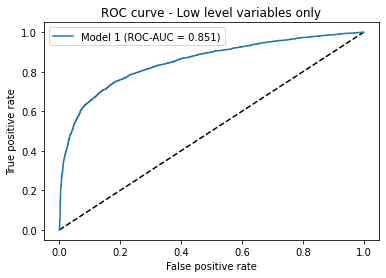

In [15]:
import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Low level variables only')
plt.legend(loc='best')
plt.show()

PCA


In [16]:
from sklearn.decomposition import IncrementalPCA


n_batches=100

d=4
  
inc_pca = IncrementalPCA(n_components=d)
for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_train_reduced = inc_pca.transform(X_train)
X_val_reduced = inc_pca.transform(X_val)
X_test_reduced = inc_pca.transform(X_test)

model_reduced = create_model()
model_reduced.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
t1 = time.perf_counter()
model_reduced.fit(X_train_reduced, y_train, validation_data=(X_val_reduced, y_val), epochs=20, batch_size=10)
t2 = time.perf_counter()
train_time_reduced = t2-t1

loss, accuracy = model_reduced.evaluate(X_test_reduced, y_test)
  
y_pred_reduced = model_reduced.predict(X_test_reduced)
fpr, tpr, _ = roc_curve(y_test, y_pred_reduced)
roc_auc = auc(fpr, tpr)  


Epoch 1/20
3200/3200 [==============================] - 11s 3ms/step - loss: 0.5832 - accuracy: 0.7204 - val_loss: 0.5057 - val_accuracy: 0.7628
Epoch 2/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5395 - accuracy: 0.7438 - val_loss: 0.5101 - val_accuracy: 0.7661
Epoch 3/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5305 - accuracy: 0.7470 - val_loss: 0.5058 - val_accuracy: 0.7704
Epoch 4/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5308 - accuracy: 0.7462 - val_loss: 0.5012 - val_accuracy: 0.7702
Epoch 5/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5227 - accuracy: 0.7524 - val_loss: 0.5067 - val_accuracy: 0.7647
Epoch 6/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5214 - accuracy: 0.7543 - val_loss: 0.4964 - val_accuracy: 0.7711
Epoch 7/20
3200/3200 [==============================] - 10s 3ms/step - loss: 0.5212 - accuracy: 0.7581 - val_loss: 0.4942 - val_ac

In [18]:
inc_pca.components_

array([[-4.69846168e-03,  7.07283284e-01, -5.24984267e-02,
        -5.61173485e-03,  7.03969610e-01,  3.60118383e-02,
        -8.32482951e-03,  1.15615619e-03],
       [-1.92675636e-03,  4.42615650e-02,  7.19663047e-01,
         3.31506533e-03,  3.94300585e-02, -5.80555076e-01,
        -8.33330938e-03, -3.76089007e-01],
       [-9.34839703e-03,  7.70698875e-03, -5.17470419e-02,
        -7.01954656e-03,  1.69156891e-02, -5.86042181e-01,
        -1.29673851e-03,  8.08327235e-01],
       [ 5.66692355e-01, -1.71920541e-02,  1.36949433e-02,
         4.03886046e-01,  3.37333342e-02,  4.16404209e-04,
         7.16919964e-01,  1.18479236e-02]])

In [76]:
feature_names = ["lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", "lepton 2 phi", "miss. energy mag", "miss. energy phi"]

principal_components = inc_pca.components_
for d in range(len(principal_components)):
  print("Principal Axis "+str(d+1))
  for n in range(len(feature_names)):
    print(feature_names[n] + " :\t"+str(principal_components[d][n]))
  print("\n-------------\n")

Principal Axis 1
lepton 1 pT :	-0.0046984616839536916
lepton 1 eta :	0.7072832843801448
lepton 1 phi :	-0.05249842669906155
lepton 2 pT :	-0.0056117348477145446
lepton 2 eta :	0.7039696099538482
lepton 2 phi :	0.036011838308060824
miss. energy mag :	-0.008324829507514564
miss. energy phi :	0.0011561561891171345

-------------

Principal Axis 2
lepton 1 pT :	-0.001926756360735022
lepton 1 eta :	0.04426156502792717
lepton 1 phi :	0.7196630471432183
lepton 2 pT :	0.0033150653315836415
lepton 2 eta :	0.03943005847966237
lepton 2 phi :	-0.5805550757029835
miss. energy mag :	-0.008333309383483693
miss. energy phi :	-0.37608900663021877

-------------

Principal Axis 3
lepton 1 pT :	-0.009348397028420174
lepton 1 eta :	0.007706988747308286
lepton 1 phi :	-0.05174704188089206
lepton 2 pT :	-0.007019546562155966
lepton 2 eta :	0.016915689142547756
lepton 2 phi :	-0.5860421811407974
miss. energy mag :	-0.001296738511425373
miss. energy phi :	0.8083272352666891

-------------

Principal Axis 4
le